<a href="https://colab.research.google.com/github/Akage1234/Pytorch-mini-projects/blob/main/NLP/LSTM_GRU/IMDB_Sentiment_analysis_Using_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import random
import numpy as np

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

using device: cuda


In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. Loading Dataset

Import from kaggle

In [ ]:
from google.colab import files
key = files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install -q kaggle

In [ ]:
!kaggle datasets download pawankumargunjan/imdb-review

Dataset URL: https://www.kaggle.com/datasets/pawankumargunjan/imdb-review
License(s): GNU Lesser General Public License 3.0
 99% 110M/111M [00:00<00:00, 1.11GB/s]
100% 111M/111M [00:00<00:00, 1.08GB/s]


In [ ]:
!mkdir -p imdb
!unzip -q imdb-review.zip -d imdb

or download manually from https://www.kaggle.com/datasets/pawankumargunjan/imdb-review/data

In [ ]:
import os

train_texts, train_labels = [], []
test_texts, test_labels = [], []

for label_type in ["pos", "neg"]:
    train_dir = f"/content/imdb/aclImdb/train/{label_type}"
    for filename in os.listdir(train_dir):
        if filename.endswith(".txt"):
            with open(os.path.join(train_dir, filename), "r", encoding="utf-8") as f:
                train_texts.append(f.read())
            train_labels.append(1 if label_type == "pos" else 0)

    test_dir = f"/content/imdb/aclImdb/test/{label_type}"
    for filename in os.listdir(test_dir):
        if filename.endswith(".txt"):
            with open(os.path.join(test_dir, filename), "r", encoding="utf-8") as f:
                test_texts.append(f.read())
            test_labels.append(1 if label_type == "pos" else 0)

In [ ]:
print(len(train_texts), len(train_labels))
print(len(test_texts), len(test_labels))

25000 25000
25000 25000


In [ ]:
# downloading embeddings
import requests
import zipfile
import os

def download_glove(url: str, save_path: str):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(save_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

url = "https://nlp.stanford.edu/data/wordvecs/glove.2024.wikigiga.100d.zip"
save_path = "glove.2024.wikigiga.100d.zip"
glove_path = "./glove_100d"

os.makedirs(glove_path, exist_ok=True)
download_glove(url, save_path)
with zipfile.ZipFile(save_path, 'r') as z:
    z.extractall(glove_path)

print("Downloaded & extracted to:", glove_path)

Downloaded & extracted to: ./glove_100d


# 2. Preprocessing

In [ ]:
import nltk
from collections import Counter

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
def build_vocab(texts, min_freq = 2, max_size=20000):
    counter = Counter()
    for text in texts:
        counter.update(nltk.word_tokenize(text))

    vocab = {"<pad>":0, "<unk>":1}

    for word, freq in counter.most_common(max_size - len(vocab)):
        if freq >= min_freq:
            vocab[word] = len(vocab)

    return vocab

word2idx = build_vocab(train_texts)
idx2word = {i: w for w, i in word2idx.items()}

In [ ]:
import pickle

# saving vocab
vocab = {"word2idx": word2idx, "idx2word": idx2word}
with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

In [ ]:
def collate_fn(batch):
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(t) for t in texts], dtype=torch.long)
    max_len = lengths.max().item()

    padded = torch.zeros(len(texts), max_len, dtype=torch.long) + word2idx["<pad>"]
    for i, t in enumerate(texts):
        padded[i, :len(t)] = t

    labels = torch.tensor(labels, dtype=torch.long)
    return padded, labels, lengths

def preprocess(text):
    tokens = nltk.word_tokenize(text)
    ids = [word2idx.get(tok, word2idx["<unk>"]) for tok in tokens]
    return torch.tensor(ids, dtype=torch.long)

In [ ]:
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from sklearn.model_selection import train_test_split

class IMDBDataset(Dataset):
    def __init__(self, texts, labels, transform=None):
        self.texts = texts
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, id):
        texts, labels = self.texts[id], self.labels[id]
        if self.transform:
            texts = self.transform(texts)
        return texts, labels

train_x, val_x, train_y, val_y = train_test_split(train_texts, train_labels,test_size=0.2, stratify=train_labels,random_state=42)

train_data = IMDBDataset(train_x, train_y, transform=preprocess)
val_data = IMDBDataset(val_x, val_y, transform=preprocess)
test_data = IMDBDataset(test_texts, test_labels, transform=preprocess)

In [ ]:
train_loader = DataLoader(train_data,batch_size=64, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, collate_fn = collate_fn, num_workers=2, pin_memory=True)

# 3. Model

In [ ]:
# Building Embedding matrix
glove_path = '/content/glove_100d/wiki_giga_2024_100_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05.050_combined.txt'
def building_embedding_matrix(word2idx, glove_path=glove_path,embed_dim=100 ):
    embeddings_idx = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            values = line.strip().strip("'")
            values = values.split()
            word = values[0]
            try:
                vector = np.asarray(values[1:], dtype=np.float32)
                if len(vector) != embed_dim:
                    continue
                embeddings_idx[word] = vector
            except ValueError:
                continue
    print(f"Loaded {len(embeddings_idx)} word vectors.")
    vocab_size = len(word2idx)
    embedding_matrix = np.random.normal(0, 0.1, (vocab_size, embed_dim))
    for word, idx in word2idx.items():
        if word in embeddings_idx:
            embedding_matrix[idx] = embeddings_idx[word]

    return torch.tensor(embedding_matrix, dtype=torch.float32)

embedding_matrix = building_embedding_matrix(word2idx)

Loaded 1287490 word vectors.


In [ ]:
embedding_matrix

tensor([[ 4.9671e-02, -1.3826e-02,  6.4769e-02,  ...,  2.6106e-02,
          5.1135e-04, -2.3459e-02],
        [-1.5577e-01, -7.3595e-02,  2.1258e-01,  ..., -2.8095e-02,
         -9.4901e-02,  4.1100e-04],
        [ 3.0672e-01, -3.2053e-01, -3.9365e-01,  ...,  1.2716e-01,
         -2.9899e-02,  2.4711e-01],
        ...,
        [ 3.5891e-01, -8.5166e-01,  3.8297e-02,  ..., -1.4017e+00,
          3.2602e-01, -2.2778e-01],
        [ 3.5972e-01, -1.4532e-01,  5.8886e-01,  ..., -5.5901e-02,
         -1.9415e-01, -5.7123e-01],
        [ 2.6368e-01,  3.4892e-01,  3.5927e-01,  ...,  4.3119e-01,
          1.3961e-02, -1.9262e-01]])

In [ ]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.lstm = nn.LSTM(embed_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths):
        x = self.embedding(x)
        lengths = lengths.view(-1).cpu()
        packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (h_n, c_n) = self.lstm(packed_x)
        last_hidden = h_n[-1]
        out = self.fc(last_hidden)
        return out

class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.gru = nn.GRU(embed_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths):
        x = self.embedding(x)
        output,  h_n = self.gru(x)
        last_indices = lengths - 1
        last_indices = last_indices.view(-1, 1, 1).expand(-1, 1, self.fc.in_features)
        last_output = torch.gather(output, 1, last_indices).squeeze(1)
        out = self.fc(last_output)
        return out

In [ ]:
vocab_size = len(word2idx)
embed_size = 100
hidden_size = 128
output_size = 2
lstm_model = LSTMModel(vocab_size, embed_size, hidden_size, output_size)
lstm_model = lstm_model.to(device)
gru_model = GRUModel(vocab_size, embed_size, hidden_size, output_size)
gru_model = gru_model.to(device)

# 4. Training (To use pretrained skip to 6. Testing)

In [ ]:
import torch.optim as optim
from tqdm import tqdm

In [ ]:
n_epochs = 10
learning_rate = 1e-4
optimizerLSTM = optim.Adam(lstm_model.parameters(), lr=learning_rate)
optimizerGRU = optim.Adam(gru_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, n_epochs=5, learning_rate=1e-3):
    best_val_loss = float("inf")
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(n_epochs):
        with tqdm(len(train_loader)+len(val_loader), desc=f"Epoch:{epoch+1}/{n_epochs}") as pbar:
            model.train()
            total_loss, correct, total = 0.0, 0, 0
            for batch, labels, lengths in train_loader:
                batch = batch.to(device)
                labels = labels.to(device)
                lengths = lengths.to(device)

                pred = model(batch, lengths)
                loss = criterion(pred, labels)
                total_loss += loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                preds = pred.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                pbar.update(1)

            avg_train_loss = total_loss/len(train_loader)
            train_acc = 100 * correct / total
            train_losses.append(avg_train_loss)
            train_accs.append(train_acc)

            model.eval()
            val_loss, correct, total = 0, 0, 0
            with torch.no_grad():
                for batch, labels, lengths in val_loader:
                    batch, labels, lengths = batch.to(device), labels.to(device), lengths.to(device)

                    pred = model(batch, lengths)
                    loss = criterion(pred, labels)
                    val_loss += loss.item()

                    preds = pred.argmax(dim=1)
                    correct += (preds==labels).sum().item()
                    total += labels.size(0)

                    pbar.update(1)

            avg_val_loss = val_loss/len(val_loader)
            val_acc = 100 * correct / total
            val_losses.append(avg_val_loss)
            val_accs.append(val_acc)

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(),f"best_{model.__class__.__name__}.pth")

        print(f"Epoch: {epoch+1}/{n_epochs} | train_loss:{avg_train_loss:.4f} | train_accuracy:{train_acc:.2f} | val_loss: {avg_val_loss:.4f} | val_accuracy:{val_acc:.2f}")
    return train_losses, val_losses, train_accs, val_accs

In [ ]:
train_losses, val_losses, train_accs, val_accs = train_model(lstm_model, train_loader, val_loader, optimizerLSTM, criterion, n_epochs, learning_rate)

Epoch:1/10: 392it [00:45,  8.63it/s]


Epoch: 1/10 | train_loss:0.6040 | train_accuracy:66.92 | val_loss: 0.4480 | val_accuracy:80.54


Epoch:2/10: 392it [00:42,  9.27it/s]


Epoch: 2/10 | train_loss:0.4283 | train_accuracy:81.80 | val_loss: 0.4114 | val_accuracy:81.52


Epoch:3/10: 392it [00:42,  9.26it/s]


Epoch: 3/10 | train_loss:0.3827 | train_accuracy:84.23 | val_loss: 0.3842 | val_accuracy:83.70


Epoch:4/10: 392it [00:41,  9.35it/s]


Epoch: 4/10 | train_loss:0.3086 | train_accuracy:87.93 | val_loss: 0.3336 | val_accuracy:86.30


Epoch:5/10: 392it [00:44,  8.81it/s]


Epoch: 5/10 | train_loss:0.2695 | train_accuracy:89.64 | val_loss: 0.3171 | val_accuracy:86.76


Epoch:6/10: 392it [00:41,  9.39it/s]


Epoch: 6/10 | train_loss:0.2542 | train_accuracy:90.47 | val_loss: 0.3240 | val_accuracy:87.66


Epoch:7/10: 392it [00:42,  9.20it/s]


Epoch: 7/10 | train_loss:0.2268 | train_accuracy:91.52 | val_loss: 0.3218 | val_accuracy:86.22


Epoch:8/10: 392it [00:42,  9.25it/s]


Epoch: 8/10 | train_loss:0.2035 | train_accuracy:92.70 | val_loss: 0.2974 | val_accuracy:88.28


Epoch:9/10: 392it [00:41,  9.36it/s]


Epoch: 9/10 | train_loss:0.1884 | train_accuracy:93.35 | val_loss: 0.3007 | val_accuracy:87.92


Epoch:10/10: 392it [00:41,  9.39it/s]

Epoch: 10/10 | train_loss:0.1746 | train_accuracy:93.98 | val_loss: 0.3497 | val_accuracy:88.36


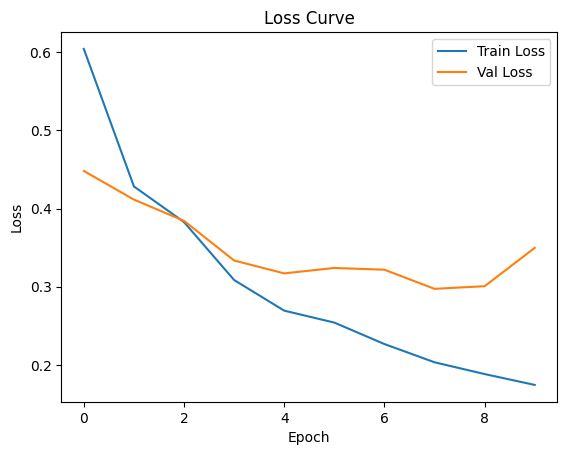

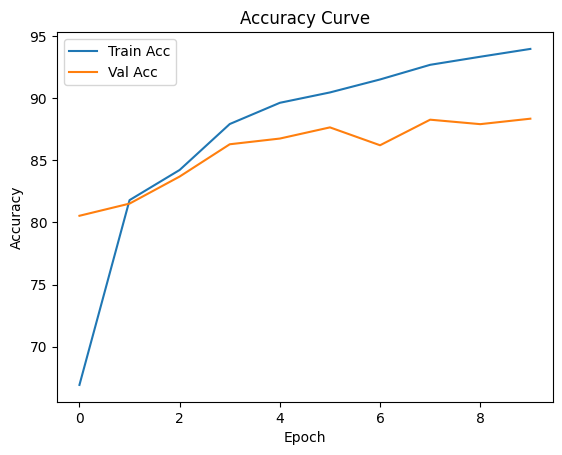

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.show()

In [ ]:
train_losses, val_losses, train_accs, val_accs = train_model(gru_model, train_loader, val_loader, optimizerGRU, criterion, n_epochs, learning_rate)

Epoch:1/10: 392it [00:35, 11.17it/s]


Epoch: 1/10 | train_loss:0.6427 | train_accuracy:63.56 | val_loss: 0.4956 | val_accuracy:76.94


Epoch:2/10: 392it [00:32, 11.90it/s]


Epoch: 2/10 | train_loss:0.3866 | train_accuracy:83.83 | val_loss: 0.3581 | val_accuracy:84.72


Epoch:3/10: 392it [00:32, 12.04it/s]


Epoch: 3/10 | train_loss:0.2944 | train_accuracy:88.59 | val_loss: 0.3449 | val_accuracy:85.52


Epoch:4/10: 392it [00:33, 11.65it/s]


Epoch: 4/10 | train_loss:0.2507 | train_accuracy:90.47 | val_loss: 0.3106 | val_accuracy:87.42


Epoch:5/10: 392it [00:32, 11.97it/s]


Epoch: 5/10 | train_loss:0.2190 | train_accuracy:91.94 | val_loss: 0.2974 | val_accuracy:87.74


Epoch:6/10: 392it [00:32, 12.08it/s]


Epoch: 6/10 | train_loss:0.1901 | train_accuracy:93.30 | val_loss: 0.2951 | val_accuracy:88.10


Epoch:7/10: 392it [00:34, 11.53it/s]


Epoch: 7/10 | train_loss:0.1729 | train_accuracy:94.06 | val_loss: 0.2881 | val_accuracy:88.66


Epoch:8/10: 392it [00:33, 11.61it/s]


Epoch: 8/10 | train_loss:0.1550 | train_accuracy:94.85 | val_loss: 0.2800 | val_accuracy:88.80


Epoch:9/10: 392it [00:33, 11.73it/s]


Epoch: 9/10 | train_loss:0.1424 | train_accuracy:95.31 | val_loss: 0.3028 | val_accuracy:89.32


Epoch:10/10: 392it [00:32, 11.89it/s]

Epoch: 10/10 | train_loss:0.1639 | train_accuracy:94.10 | val_loss: 0.2857 | val_accuracy:88.80


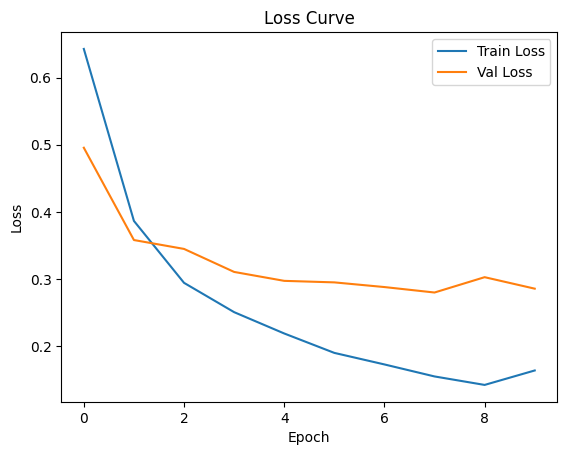

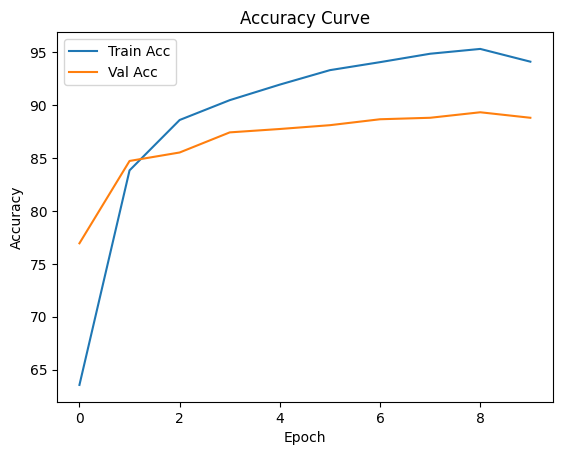

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.show()

# 5. Validation

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
model = LSTMModel(vocab_size, embed_size, hidden_size, output_size).to(device)
model.load_state_dict(torch.load(f"best_{model.__class__.__name__}.pth"))
model.eval()

LSTMModel(
  (embedding): Embedding(20000, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
test_loss, correct, total = 0, 0, 0
all_preds = []
all_labels = []
with torch.no_grad():
    for batch, labels, lengths in test_loader:
        batch, labels, lengths = batch.to(device), labels.to(device), lengths.to(device)
        pred = model(batch, lengths)

        loss = criterion(pred, labels)
        test_loss += loss.item()

        preds = pred.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_acc = 100 * correct / total
print(f"Validation Loss: {avg_test_loss:.4f} | Validation Accuracy: {test_acc:.2f}%")

Validation Loss: 0.3313 | Validation Accuracy: 86.87%


In [ ]:
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.86      0.88      0.87     12500
    Positive       0.87      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



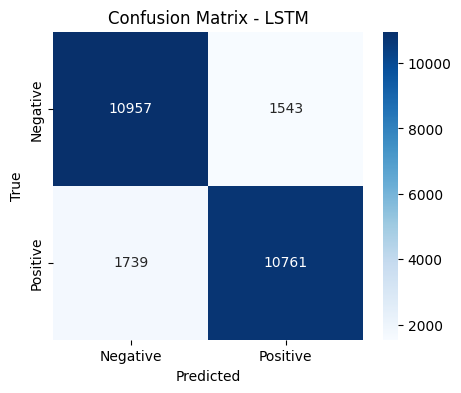

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative","Positive"],
            yticklabels=["Negative","Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - LSTM")
plt.show()

In [ ]:
model = GRUModel(vocab_size, embed_size, hidden_size, output_size).to(device)
model.load_state_dict(torch.load(f"best_{model.__class__.__name__}.pth"))
model.eval()

GRUModel(
  (embedding): Embedding(20000, 100)
  (gru): GRU(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
test_loss, correct, total = 0, 0, 0
all_preds = []
all_labels = []
with torch.no_grad():
    for batch, labels, lengths in test_loader:
        batch, labels, lengths = batch.to(device), labels.to(device), lengths.to(device)
        pred = model(batch, lengths)

        loss = criterion(pred, labels)
        test_loss += loss.item()

        preds = pred.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_acc = 100 * correct / total
print(f"Validation Loss: {avg_test_loss:.4f} | Validation Accuracy: {test_acc:.2f}%")

Validation Loss: 0.3109 | Validation Accuracy: 87.62%


In [ ]:
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.87      0.88      0.88     12500
    Positive       0.88      0.87      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



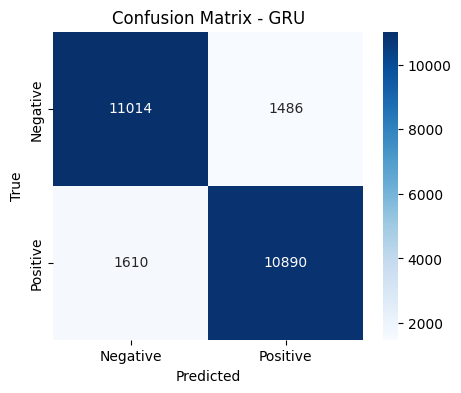

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative","Positive"],
            yticklabels=["Negative","Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - GRU")
plt.show()

In [ ]:
import pickle

os.makedirs('saved_models', exist_ok=True)

torch.save(lstm_model.state_dict(), "saved_models/lstm_weights.pth")
torch.save(gru_model.state_dict(), "saved_models/gru_weights.pth")
torch.save(embedding_matrix, "saved_models/embedding_matrix.pt")

with open("saved_models/vocab.pkl", "wb") as f:
    pickle.dump({"word2idx": word2idx, "idx2word": idx2word}, f)

In [ ]:
# To download
import shutil
from google.colab import files
shutil.make_archive("saved_models", 'zip', "saved_models")
# files.download("saved_models.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 6. Testing

In [ ]:
# loading pretrained models, embeddings, vocab

import requests, zipfile, io, os

url = "https://github.com/Akage1234/Pytorch-mini-projects/raw/main/NLP/LSTM_GRU/saved_models.zip"

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("saved_models")

In [ ]:
import torch
import pickle

with open("saved_models/vocab.pkl", "rb") as f:
    vocab_data = pickle.load(f)
word2idx = vocab_data["word2idx"]
idx2word = vocab_data["idx2word"]

embedding_matrix = torch.load("saved_models/embedding_matrix.pt")

lstm_model = LSTMModel(vocab_size=len(word2idx), embed_size=100, hidden_size=128, output_size=2)
gru_model  = GRUModel(vocab_size=len(word2idx), embed_size=100, hidden_size=128, output_size=2)

lstm_model.load_state_dict(torch.load("saved_models/lstm_weights.pth"))
gru_model.load_state_dict(torch.load("saved_models/gru_weights.pth"))

device = "cuda" if torch.cuda.is_available() else "cpu"
lstm_model.to(device)
gru_model.to(device)

GRUModel(
  (embedding): Embedding(20000, 100)
  (gru): GRU(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
import torch
import nltk

def preprocess_text(text, word2idx):
    tokens = nltk.word_tokenize(text.lower())
    ids = [word2idx.get(tok, word2idx["<unk>"]) for tok in tokens]
    return torch.tensor(ids, dtype=torch.long)

def predict_sentiment(model, text, device):
    model.eval()
    with torch.no_grad():
        input_ids = preprocess_text(text, word2idx).unsqueeze(0).to(device)  # Add batch dim
        lengths = torch.tensor([input_ids.size(1)]).to(device)
        output = model(input_ids, lengths)
        pred = torch.argmax(output, dim=1).item()
        return "Positive" if pred == 1 else "Negative"

user_input = input("Enter your review: ")
model_choice = input("Choose model (lstm/gru): ").lower()

model = lstm_model if model_choice == "lstm" else gru_model

prediction = predict_sentiment(model, user_input, device)
print(f"Predicted sentiment: {prediction}")

Enter your review: Amazing movie. Dont miss!
Choose model (lstm/gru): lstm
Predicted sentiment: Positive
